<a href="https://colab.research.google.com/github/beladinaelfitri/machine_learning/blob/master/fixedjgnjgnbgs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis for Indonesian Text - Training Part

This notebook is a source that used for Gemastik 2020 Data Mining.

Created by:

Team: NamaTimnyaApa

Member
- Angela Marpaung
- Beladina Elfitri
- IGB Vayupranaditya P

University: Telkom Universiy

This is a modification of https://github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb using the Tensorflow 2.0 Keras implementation of DistilBERT from 

#BERT from [kpe/bert-for-tf2](https://github.com/kpe/bert-for-tf2) with the original [google-research/bert](https://github.com/google-research/bert) weights.

# Predicting Twitter Sentiment with DistilBERT

First install some prerequisites:

In [1]:
!pip install tqdm 

In [2]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf


In [3]:
tf.__version__

'2.3.0'

In [4]:
if tf.__version__.startswith("1."):
  tf.enable_eager_execution()


In addition to the standard libraries we imported above, we'll need to install the [bert-for-tf2](https://github.com/kpe/bert-for-tf2) python package, and do the imports required for loading the pre-trained weights and tokenizing the input text. 

In [5]:
!pip install bert-for-tf2==0.11.6 

  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.11.6-cp36-none-any.whl size=23182 sha256=a6a775bbb2c09ae90a5d5c759c2d24db194e49005047ea1dec24686a5205e6ba
  Stored in directory: /root/.cache/pip/wheels/fe/3e/0e/35f86016885433be80838675b9572aad8566552b71c7d5760a
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=940b4664daafdbdcaadb1f64a75cdad1a4cc166889ad99ac1a3bf457bd780902
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=850082b40e12de57b75b39a97fb6b8d8aae7b18b7f6793ea0820c60d50e1115b
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [6]:
!pip install transformers

     |████████████████████████████████| 890kB 2.9MB/s 
     |████████████████████████████████| 3.0MB 16.1MB/s 
     |████████████████████████████████| 890kB 24.9MB/s 
     |████████████████████████████████| 1.1MB 40.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7cb025d4c2195f1dbeb5b30d116ebdb1908ee7c32fd65acfc33ceafeb4f5acaf
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [7]:
from transformers import DistilBertModel, DistilBertConfig, TFDistilBertForSequenceClassification

#Data

The dataset used is based from http://ridi.staff.ugm.ac.id/2019/03/06/indonesia-sentiment-analysis-dataset/

The dataset is already cleanied and formatted to only contains positive (1) and negative (0).

Dataset can be downloaded from https://drive.google.com/open?id=1TiaMpQZe99dPpC7_YuTy87wzW8bVWpYa

The data is saved on my own google drive, if you want to run this notebook please change dataset location

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from tensorflow import keras
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  df = pd.read_csv("/content/drive/My Drive/Data Mining-Jangan Jangan Bagus/indo_dataset.csv")
  df.Tweet = df.Tweet.str.lower()
  
  df_train, df_test = train_test_split(df,  test_size=0.2)
  
  return df_train, df_test


Specify BERT model and trained model location 

In [10]:
model_save_location = "drive/My Drive/Data Mining-Jangan Jangan Bagus/bert_model/sentiment_result_fixed_1.h5"

Let's use the `TwitterSentimentData` class below, to prepare/encode 
the data for feeding into our BERT model, by:
  - tokenizing the text
  - trim or pad it to a `max_seq_len` length
  - append the special tokens `[CLS]` and `[SEP]`
  - convert the string tokens to numerical `ID`s using the original model's token encoding from `vocab.txt`

In [11]:
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization import FullTokenizer


class TwitterSentimentData:
    DATA_COLUMN = "Tweet"
    LABEL_COLUMN = "sentimen"

    def __init__(self, tokenizer: FullTokenizer, sample_size=None, max_seq_len=1024):
        self.tokenizer = tokenizer
        self.sample_size = sample_size
        self.max_seq_len = max_seq_len
        train, test = download_and_load_datasets()
        
        train, test = map(lambda df: df.reindex(df[TwitterSentimentData.DATA_COLUMN].str.len().sort_values().index), 
                          [train, test])
                
        if sample_size is not None:
            assert sample_size % 128 == 0
            train, test = train.head(sample_size), test.head(sample_size)
        
        ((self.train_x, self.train_y),
         (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        ((self.train_x, self.train_x_token_types),
         (self.test_x, self.test_x_token_types)) = map(self._pad, 
                                                       [self.train_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
        with tqdm(total=df.shape[0], unit_scale=True) as pbar:
            for ndx, row in df.iterrows():
                text, label = row[TwitterSentimentData.DATA_COLUMN], row[TwitterSentimentData.LABEL_COLUMN]
                tokens = self.tokenizer.tokenize(text)
                tokens = ["[CLS]"] + tokens + ["[SEP]"]
                token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
                self.max_seq_len = max(self.max_seq_len, len(token_ids))
                x.append(token_ids)
                y.append(int(label))
                pbar.update()
        return np.array(x), np.array(y)

    def _pad(self, ids):
        x, t = [], []
        token_type_ids = [0] * self.max_seq_len
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
            t.append(token_type_ids)
        return np.array(x), np.array(t)


# Preparing the Data

Now let's fetch and prepare the data by taking the first `max_seq_len` tokenens after tokenizing with the BERT tokenizer, und use `sample_size` examples for both training and testing.

To keep training fast, we'll take a sample of about 2500 train and test examples, respectively, and use the first 128 tokens only (transformers memory and computation requirements scale quadraticly with the sequence length - so with a TPU you might use `max_seq_len=512`, but on a GPU this would be too slow, and you will have to use a very small `batch_size`s to fit the model into the GPU memory).

In [12]:
%%time
from transformers import DistilBertForSequenceClassification,DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
data = TwitterSentimentData(tokenizer, 
                       sample_size=None, 
                       max_seq_len=128)

100%|██████████| 4.38k/4.38k [00:02<00:00, 2.02kit/s]
100%|██████████| 1.10k/1.10k [00:00<00:00, 2.01kit/s]


max seq_len 128
CPU times: user 3.1 s, sys: 58.4 ms, total: 3.16 s
Wall time: 4.37 s


In [13]:
print("            train_x", data.train_x.shape)
print("train_x_token_types", data.train_x_token_types.shape)
print("            train_y", data.train_y.shape)

print("             test_x", data.test_x.shape)

print("        max_seq_len", data.max_seq_len)

            train_x (4383, 128)
train_x_token_types (4383, 128)
            train_y (4383,)
             test_x (1096, 128)
        max_seq_len 128


## Learning Rate Scheduler


In [14]:
def create_learning_rate_scheduler(max_learn_rate=5e-5,
                                   end_learn_rate=1e-7,
                                   warmup_epoch_count=10,
                                   total_epoch_count=90):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            res = (max_learn_rate/warmup_epoch_count) * (epoch + 1)
        else:
            res = max_learn_rate*math.exp(math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler


#Creating a model


In [15]:
def create_model(max_seq_len):
  input_layer = tf.keras.layers.Input(shape = (max_seq_len,), dtype='int32')
  bert = TFDistilBertModel.from_pretrained("distilbert-base-multilingual-cased")(input_layer)

  bert = bert[0][:,0,:]    

  bert = tf.keras.layers.Dense(units=768, activation='relu')(bert)
  bert = tf.keras.layers.Dropout(0.5)(bert)

  classifier = tf.keras.layers.Dense(units=2, activation='softmax')(bert)

  model = tf.keras.models.Model(inputs=input_layer, outputs=classifier)
  model.compile(tf.keras.optimizers.Adam(lr=6e-6), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])
  model.summary()
  return model

In [16]:
from transformers import TFDistilBertModel
model = create_model(data.max_seq_len)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 128, 768),)       134734080 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_19 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1538      
Total params: 135,326,210
Trainable params: 135,326,210
Non-trainable params: 0
________________________________________

In [ ]:
%%time

log_dir = "log/sentiment/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

total_epoch_count = 50
# model.fit(x=(data.train_x, data.train_x_token_types), y=data.train_y,
model.fit(x=data.train_x, y=data.train_y,
          validation_split=0.1,
          batch_size=45,
          shuffle=True,
          epochs=total_epoch_count,
          callbacks=[create_learning_rate_scheduler(max_learn_rate=1e-5,
                                                    end_learn_rate=1e-7,
                                                    warmup_epoch_count=20,
                                                    total_epoch_count=total_epoch_count),
                     keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
                     tensorboard_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 5.000000000000001e-07.
Epoch 1/50
 1/88 [..............................] - ETA: 0s - loss: 0.7184 - acc: 0.4889WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
88/88 [==============================] - 32s 363ms/step - loss: 0.7011 - acc: 0.4990 - val_loss: 0.6893 - val_acc: 0.5467

Epoch 00002: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 2/50
88/88 [==============================] - 30s 345ms/step - loss: 0.6987 - acc: 0.5041 - val_loss: 0.6847 - val_acc: 0.5444

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5000000000000002e-06.
Epoch 3/50
88/88 [==============================] - 30s 345ms/step - loss: 0.6950 - acc: 0.5155 - val_loss: 0.6810 - val_a

In [ ]:
model.save_weights(model_save_location, overwrite=True)

# Evaluation

To evaluate the trained model, let's load the saved weights in a new model instance, and evaluate.

In [17]:
%%time

_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print(" test acc", test_acc)

35/35 [==============================] - 3s 80ms/step - loss: 0.7146 - acc: 0.4462
train acc 0.47980836033821106
 test acc 0.44616788625717163
CPU times: user 7.25 s, sys: 1.5 s, total: 8.75 s
Wall time: 16.2 s


# Prediction

For prediction, we need to prepare the input text the same way as we did for training - tokenize, adding the special `[CLS]` and `[SEP]` token at begin and end of the token sequence, and pad to match the model input shape.

In [39]:
model = create_model(data.max_seq_len)
model.load_weights('/content/drive/My Drive/Data Mining-Jangan Jangan Bagus/bert_model/sentiment_vayu_2.h5')

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
tf_distil_bert_model_2 (TFDi ((None, 128, 768),)       134734080 
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 768)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_59 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1538      
Total params: 135,326,210
Trainable params: 135,326,210
Non-trainable params: 0
________________________________________

In [40]:
%%time

_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print(" test acc", test_acc)

35/35 [==============================] - 3s 81ms/step - loss: 0.4258 - acc: 0.8869
train acc 0.8774811625480652
 test acc 0.8868613243103027
CPU times: user 7.14 s, sys: 1.55 s, total: 8.69 s
Wall time: 16.1 s


In [41]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# # compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
# model.compile(tf.keras.optimizers.Adam(lr=6e-6), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])
model.compile(tf.keras.optimizers.Adam(lr=6e-6), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['acc',f1_m,precision_m, recall_m])

# # fit the model
# history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(data.test_x, data.test_y, verbose=0)

In [23]:
loss

0.4257740080356598

In [24]:
accuracy

0.8868613243103027

In [25]:
f1_score

0.6127579808235168

In [26]:
precision

0.44732141494750977

In [27]:
recall

1.0

###Dari sini

In [42]:
from matplotlib.pyplot import show
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
def predict_sentiment(model, pred_sentences,title):
  tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
  pred_tokens    = map(tokenizer.tokenize, pred_sentences)
  pred_tokens    = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
  pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

  pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
  pred_token_ids = np.array(list(pred_token_ids))

  print('pred_token_ids', pred_token_ids.shape)

  res = model.predict(pred_token_ids).argmax(axis=-1)

  id = 0
  df_result = pd.DataFrame(columns=['tweet','sentimen'])
  for text, sentiment in zip(pred_sentences, res):
    df_result.loc[id,'tweet'] = text
    df_result.loc[id,'sentimen'] = ["negative","positive"][sentiment]
    id += 1

  sns.set(style="darkgrid")
  total = float(len(df_result)) 
  ax = sns.countplot(x="sentimen", data=df_result)
  for p in ax.patches:
      height = p.get_height()
      ax.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:1.2f}%'.format(height/total*100),
              ha="center")
  plt.title(title) 
  show()

  return df_result

pred_token_ids (879, 128)


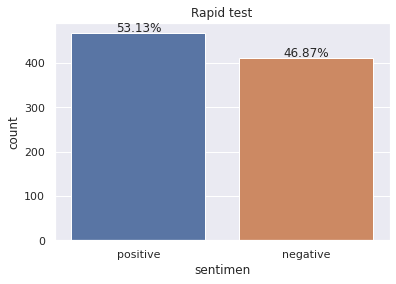

In [52]:
df_rapid = pd.read_csv("/content/drive/My Drive/Data Mining-Jangan Jangan Bagus/dataset_rapid_clean.csv")
list_rapid = df_rapid['tweet'].tolist()
df_rapid_res = predict_sentiment(model, list_rapid, 'Rapid test')

In [55]:
df_rapid_res[df_rapid_res['sentimen'] == 'positive'][:10]

,tweet,sentimen
0,viral beredar kabar soal syarat rapid test seb...,positive
1,lenovo legion x now is your chance to rise abo...,positive
2,malam kai mau nanya saya selasa sep mau ke jng...,positive
5,saat ini masih diperlukan surat keterangan neg...,positive
10,minggu pagi sept saya ada tiket ke bandung arg...,positive
11,selamat sore mengenai syarat dan ketentuan keb...,positive
13,tiap hari ketemu banyak orng udah kali test ra...,positive
15,ada salah satu universitas di solo yang mau ny...,positive
20,h bp presiden yth bgmna jika biaya swab disubs...,positive
22,unlocktheopen with and make more of that energ...,positive


pred_token_ids (819, 128)


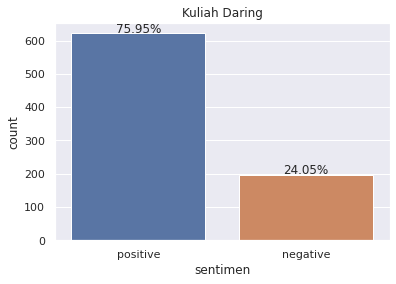

In [45]:
df_kuliah = pd.read_csv("/content/drive/My Drive/Data Mining-Jangan Jangan Bagus/dataset_kuliah_clean.csv")
list_kuliah = df_kuliah['tweet'].tolist()
predict_sentiment(model, list_kuliah, 'Kuliah Daring')

pred_token_ids (785, 128)


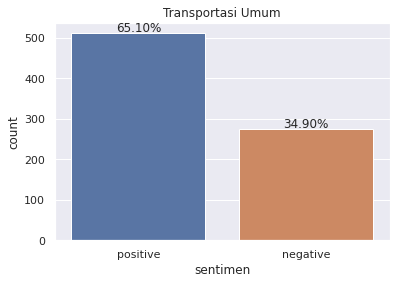

In [46]:
df_transport = pd.read_csv("/content/drive/My Drive/Data Mining-Jangan Jangan Bagus/dataset_transportasi_clean.csv")
list_transport = df_transport['tweet'].tolist()
predict_sentiment(model, list_transport, 'Transportasi Umum')

pred_token_ids (576, 128)


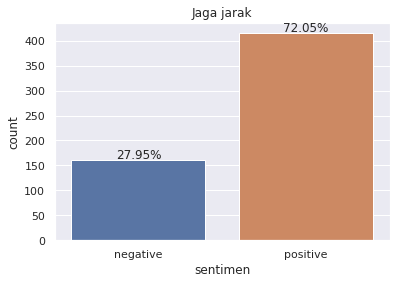

In [47]:
df_jarak = pd.read_csv("/content/drive/My Drive/Data Mining-Jangan Jangan Bagus/dataset_jarak_clean.csv")
list_jarak = df_jarak['tweet'].tolist()
predict_sentiment(model, list_jarak, 'Jaga jarak')

pred_token_ids (576, 128)


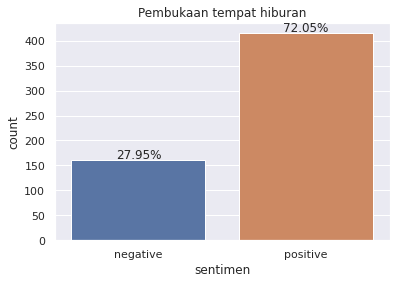

In [48]:
df_hiburan = pd.read_csv("/content/drive/My Drive/Data Mining-Jangan Jangan Bagus/dataset_hiburan_clean.csv")
list_hiburan = df_jarak['tweet'].tolist()
predict_sentiment(model, list_jarak, 'Pembukaan tempat hiburan')